In [1]:
import numpy as np
import matplotlib.pyplot as plt; plt.ion()

from scipy.io import mmread
from sklearn.decomposition import PCA
from umap import UMAP
from hdbscan import HDBSCAN

A helper function to visualize the distribution of dataset values at the various stages of preprocessing:

In [2]:
def summarize(X):
    print("Dimensions: ", X.shape)

    # compute some simple metrics to get a feel for the distribution of values
    print("Min    : ", np.min(X))
    print("Mean   : ", np.mean(X))
    print("Median : ", np.median(X))
    print("99.9%  : ", np.percentile(X.ravel(), 99.9))
    print("Max    : ", np.max(X))

    # plot distribution
    fig, ax = plt.subplots(1,1)
    ax.hist(X.ravel(), bins=100)
    ax.set_xlabel('Counts')
    ax.set_ylabel('Frequency')
    plt.show()

# Load the data:

Dimensions:  (9128, 27998)
Min    :  0
Mean   :  0.2623772026347944
Median :  0.0
99.9%  :  27.0
Max    :  6916


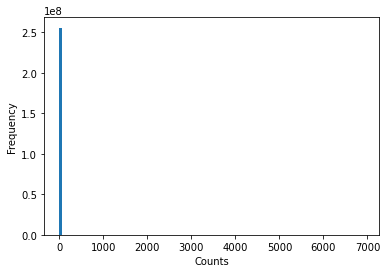

In [3]:
file_path='/ifs/obds-training/jan21/shared/python/filtered_gene_bc_matrices/mm10/matrix.mtx'
X = mmread(file_path)
X = np.array(X.todense().transpose())
summarize(X)

# Preprocess the data (a.k.a quality control)

Dimensions:  (9128,)
Min    :  2223
Mean   :  7346.036919368975
Median :  6360.5
99.9%  :  37470.50300000044
Max    :  58312


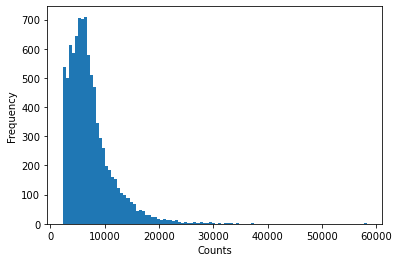

In [8]:
# Sum the total gene counts per sample
total_reads_per_sample = np.sum(X,axis=1)
summarize (total_reads_per_sample)

Dimensions:  (8965,)
Min    :  2223
Mean   :  7010.351031790296
Median :  6296.0
99.9%  :  19562.684000000037
Max    :  19963


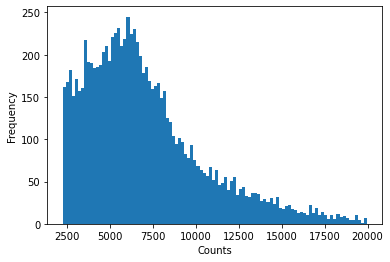

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 2, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [10]:
# Filter samples that have extremely high counts
filtered_samples = X[total_reads_per_sample<20000]
new_total_reads_per_sample = np.sum(filtered_samples, axis=1)
summarize(new_total_reads_per_sample)
X[0:10,]

Dimensions:  (27998,)
Min    :  0
Mean   :  2244.7245160368598
Median :  28.0
99.9%  :  193466.19200000027
Max    :  916304


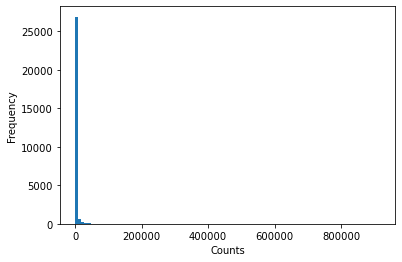

In [11]:
#Drop off genes/columns that have no reads
total_reads_per_gene = np.sum(filtered_samples,axis=0)
summarize(total_reads_per_gene)

Dimensions:  (19072,)
Min    :  1
Mean   :  3295.2913695469797
Median :  414.5
99.9%  :  221315.73800002504
Max    :  916304


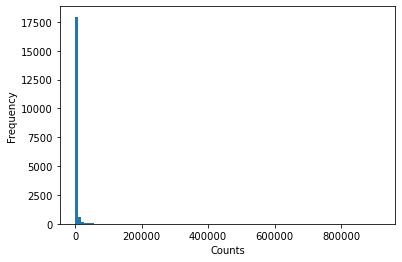

In [12]:
#Filter genes that do have have reads
expressed_genes = filtered_samples[:,total_reads_per_gene>0]
new_total_reads_per_gene = np.sum(expressed_genes, axis=0)
summarize(new_total_reads_per_gene)

Dimensions:  (19072,)
Min    :  0.00011154489682097045
Mean   :  0.13315824122145403
Median :  0.04071388733965421
99.9%  :  0.996868823201339
Max    :  0.9995538204127161


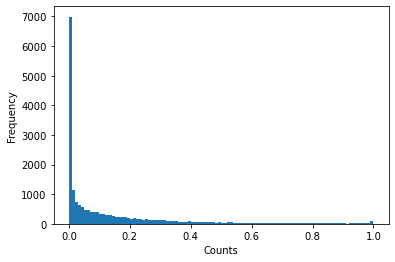

In [15]:
#Sum and calculate mean of the cell numbers that are expressing that gene. Use boolean, if the value is true, then a value of 1 is added
samples_per_genes=np.mean(expressed_genes>0,axis=0)
summarize(samples_per_genes)

Dimensions:  (8997,)
Min    :  0.05008365867261573
Mean   :  0.2713632436566666
Median :  0.1894032348020078
99.9%  :  0.9975464584495259
Max    :  0.9995538204127161


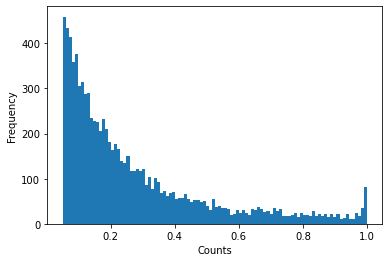

In [20]:
#Filter genes that are expressed on certain number of cells, e.g. 5%)
filtered_genes = expressed_genes[:,samples_per_genes>0.05]
new_samples_per_genes = np.mean(filtered_genes>0, axis=0)
summarize(new_samples_per_genes)

Dimensions:  (8965,)
Min    :  108
Mean   :  2441.4551031790297
Median :  2415.0
99.9%  :  4673.4320000000225
Max    :  4966


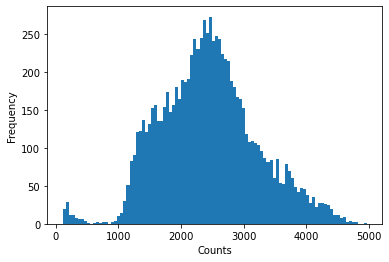

In [25]:
#Sum the gene numbers that are expressed on a cell. Use boolean, if the value is true, then a value of 1 is added
total_genes_expressed_per_sample=np.sum(filtered_genes>0,axis=1)
summarize(total_genes_expressed_per_sample)

Dimensions:  (8850,)
Min    :  1003
Mean   :  2468.6833898305085
Median :  2425.0
99.9%  :  4674.81200000002
Max    :  4966


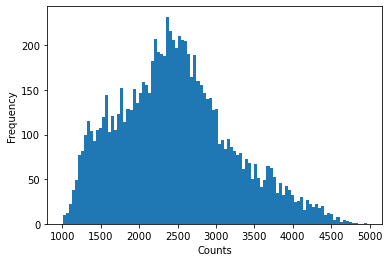

In [27]:
#Filter samples that express less number of genes, e.g. 1000 according to the plot above)
cleaned = filtered_genes[total_genes_expressed_per_sample>1000]
new_total_genes_expressed_per_sample = np.sum(cleaned>0, axis=1)
summarize(new_total_genes_expressed_per_sample)

# Transform the data to make it more normally distributed

Dimensions:  (8850, 8997)
Min    :  0.0
Mean   :  0.2851408507330191
Median :  0.0
99.9%  :  3.828641396489095
Max    :  8.448057452581375


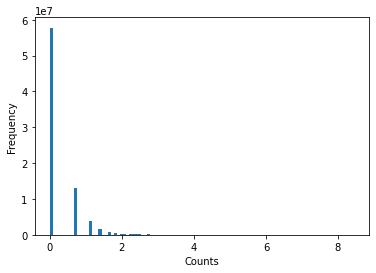

In [28]:
#log (x+1) transform
log_transformed = np.log1p(cleaned) # equivalent: log_transformed = np.log(cleaned+1)
summarize (log_transformed)

Dimensions:  (8850, 8997)
Min    :  0.0
Mean   :  0.279360617991232
Median :  0.0
99.9%  :  2.5649493574615367
Max    :  2.5649493574615367


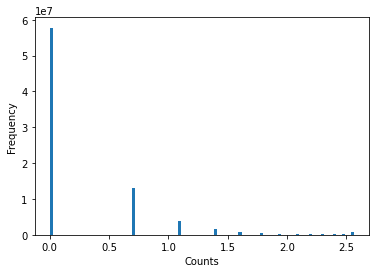

In [30]:
#Truncate large values
cutoff=np.percentile(log_transformed, 99)
#truncated=log_transformed.copy()
#truncated(truncated>cutoff)=cutoff
truncated=np.clip(log_transformed, 0, cutoff)#same as the above code
summarize(truncated)

Dimensions:  (8850, 8997)
Min    :  -29.207258201638812
Mean   :  3.3139590868574098e-15
Median :  -0.3390229894125059
99.9%  :  5.222246756575116
Max    :  13.406282107728671


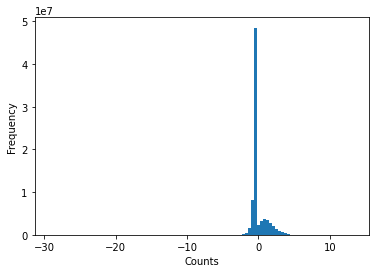

In [31]:
#convert to Z-scores
mean=truncated.mean(axis=0)
std=truncated.std(axis=0)
normalized = (truncated-mean)/std
summarize(normalized)

# Dimensionality reduction using PCA

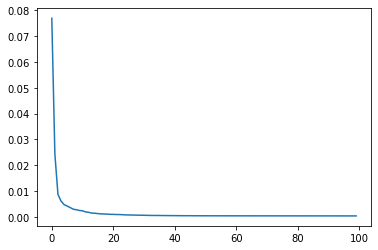

In [33]:
#set the number of components in the PCA (otherwise it will default to the number of components in our data)
pca_instance=PCA(n_components=100)
pca_instance.fit(normalized) #fit is to do PCA on the data
plt.plot(pca_instance.explained_variance_ratio_) #plot the variances to figure out the sensible number of components
#The graph shows that >20 components brings diminishing returens

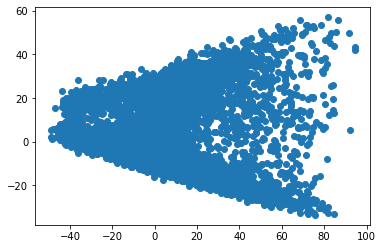

In [34]:
# Transform the PCA by using the new number of components
pca_instance=PCA(n_components=20)
pca_instance.fit(normalized)
pca_transformed=pca_instance.transform(normalized) # This is to give us a new array that is re-mapped with reduced dimensions
#Plot the first 2 components
plt.plot(pca_transformed[:,0],pca_transformed[:,1],'o') #'o' is to plot the dots
#x=principle component 1, y=principle component 2

# Dimensionality reduction using UMAP

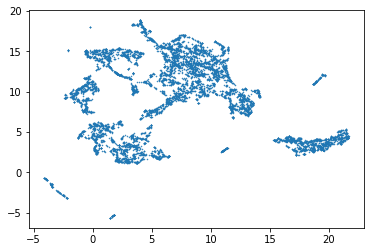

In [54]:
umap_instance=UMAP(n_components=2, n_neighbors = 5, min_dist=0.05) #Set number of components to 2
umap_transformed=umap_instance.fit_transform(pca_transformed) #Do fit and transform in one go
plt.plot(umap_transformed[:,0],umap_transformed[:,1],'o',markersize=0.5)

# Clustering using HDBSCAN

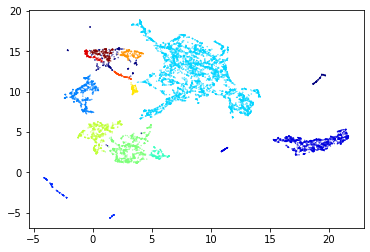

In [57]:
hdbscan_instance=HDBSCAN(min_samples=10,min_cluster_size=100)
# min_samples is the minimum numbers of neighbours in the cluster, the higher the more conservative the cluster, and more points will be declared as noise.
# min_cluster_size is the minimum numbers of samples in the cluster
lables=hdbscan_instance.fit_predict(umap_transformed)
plt.scatter(umap_transformed[:,0],umap_transformed[:,1],s=0.1, c=lables.astype(np.int),cmap='jet')